# Machine Learning Project

## Background

Automatic fake news detection is a challenging problem in deception detection, and it has tremendous real-world political and social impacts. However, statistical approaches to combating fake news has been dramatically limited by the lack of labeled benchmark datasets. Here, we use LIAR: a new, publicly available dataset for fake news detection. It is a collection a decade-long, 12.8K manually labeled short statements in various contexts from POLITIFACT.COM, which provides detailed analysis report and links to source documents for each case. We will use this dataset to help train our model to detect Fake News to combat the rapid of false information. 


https://arxiv.org/pdf/1705.00648v1.pdf

## Dataset

The LIAR dataset includes 12.8K human labeled short statements from POLITIFACT.COM’s API, and each statement is evaluated by a POLITIFACT.COM editor for its truthfulness. There were six fine-grained labels for the truthfulness ratings: pants-fire, false, barelytrue, half-true, mostly-true, and true. The distribution of labels in the LIAR dataset is relatively well-balanced: except for 1,050 pants-fire cases, the instances for all other labels range from 2,063 to 2,638. 200 instances were randomly sampled in the above paper to examine the accompanied lengthy analysis reports and rulings. The verdict requires extensive training in journalism for finding relevant evidence. Therefore, for second-stage verifications, the individuals went through a randomly sampled subset of the analysis reports and confirmed they agreeded with the reporters’ analysis. 


There is also a rich set of meta-data for each speaker—in addition to party affiliations, current job, home state, and credit history are also provided. In particular, the credit history includes the historical counts of inaccurate statements for each
speaker. For example, Mitt Romney has a credit history vector h = {19, 32, 34, 58, 33}, which corresponds to his counts of “pants on fire”, “false”, “barely true”, “half true”, “mostly true” for historical statements. Since this vector also includes the count for the current statement, we have subtracted the current label from the credit history when using this meta data vector in prediction experiments These statements are sampled from various of contexts/venues, and the top categories include news releases, TV/radio interviews, campaign speeches, TV ads, tweets, debates, Facebook posts, etc. To ensure a broad coverage o the topics, there is also a diverse set of subjects discussed by the speakers.


In [1]:
from datasets import list_datasets

In [1]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("liar")

Using custom data configuration default
Reusing dataset liar (C:\Users\brand\.cache\huggingface\datasets\liar\default\1.0.0\479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 10269
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1283
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1284
    })
})

In [3]:
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])
validation= pd.DataFrame(dataset['validation'])

In [27]:
y_train = train['label']
y_test = test['label']
y_validation = test['label']

In [28]:
X_train = train.drop('label', axis = 1)
X_test = test.drop('label', axis = 1)
X_validation = validation.drop('label', axis = 1)

In [29]:
X_train.head()

,id,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


## TO DOS

- Perform EDA on the above
- Do some slight prepossesing (one hot encoding for some variables, etc.)
- begin modeling. I think we could try our hand at building our own model from scratch and then I think we can do some transfer learning for the other (BERT, or something that has been pre-trained. I know he said that pre-trained models are good for datasets that don't have a lot of samples)

### EDA

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# create full DataFrame including all sub-datsets
df_full = pd.concat([train, test, validation])

In [6]:
# no nulls, empty fields are intentional
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12836 entries, 0 to 1283
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    12836 non-null  object 
 1   label                 12836 non-null  int64  
 2   statement             12836 non-null  object 
 3   subject               12836 non-null  object 
 4   speaker               12836 non-null  object 
 5   job_title             12836 non-null  object 
 6   state_info            12836 non-null  object 
 7   party_affiliation     12836 non-null  object 
 8   barely_true_counts    12836 non-null  float64
 9   false_counts          12836 non-null  float64
 10  half_true_counts      12836 non-null  float64
 11  mostly_true_counts    12836 non-null  float64
 12  pants_on_fire_counts  12836 non-null  float64
 13  context               12836 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 1.5+ MB


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

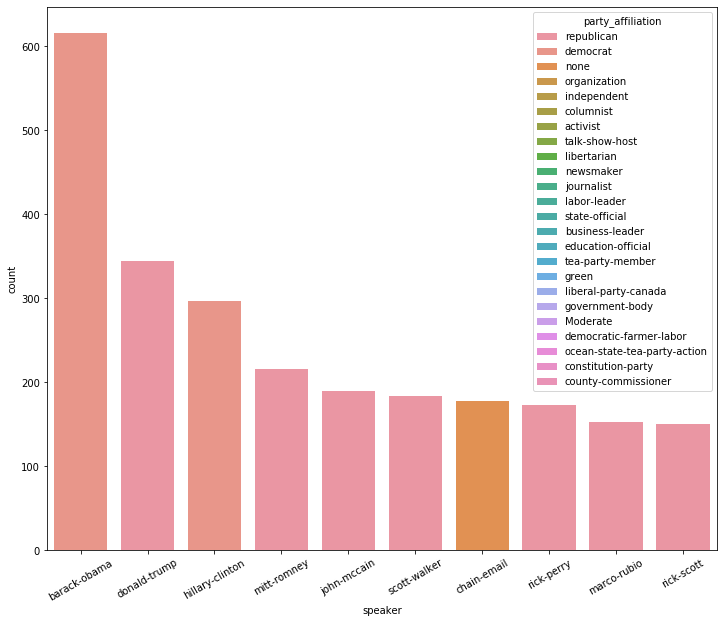

In [127]:
# plot news count by Top Speakers

plt.figure(figsize=(12,10))
ax = sns.countplot(x='speaker', data= df_full, hue='party_affiliation', 
                   order=df_full['speaker'].value_counts().iloc[:10].index, dodge=False)
plt.xticks(rotation = 30)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

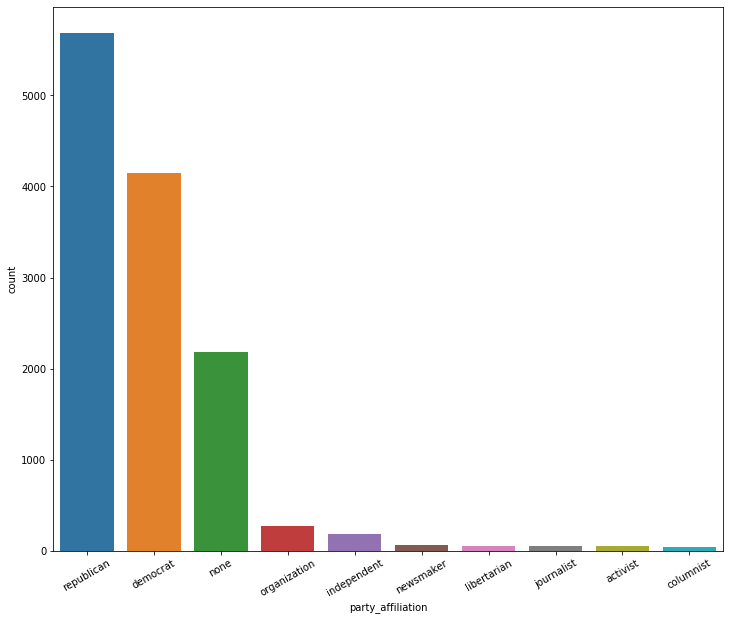

In [128]:
# plot new count by party affiliation

plt.figure(figsize=(12,10))
ax = sns.countplot(x='party_affiliation', data= df_full, 
                   order=df_full['party_affiliation'].value_counts().iloc[:10].index, dodge=False)
plt.xticks(rotation = 30)


C:\Users\brand\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

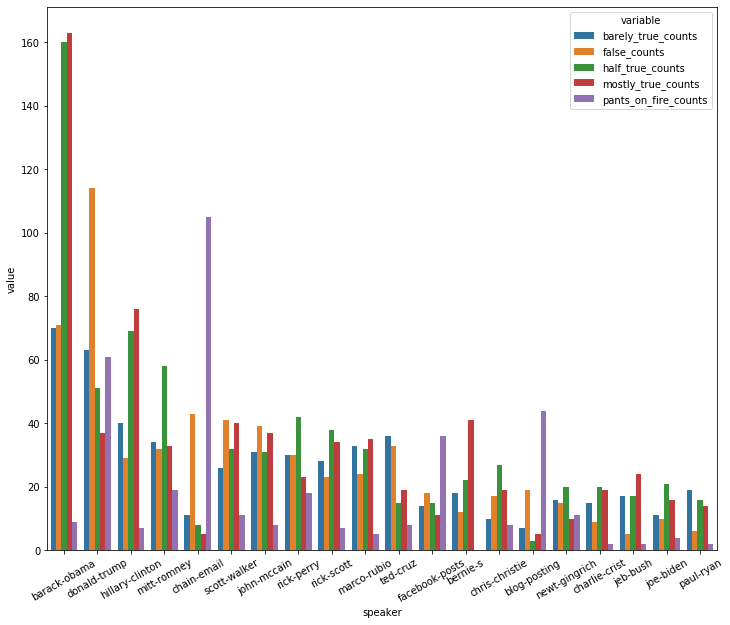

In [129]:
# Create melted DF of Category Counts
# Plot Top Speakers' Category Counts

df_speaker_TF = df_full.drop_duplicates(subset='speaker')
df_speaker_TF['news_count'] = df_speaker_TF[['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']].sum(axis = 1)
df_most_speeches = df_speaker_TF.sort_values(by=['news_count'], ascending=False)[:20].drop(['news_count'], axis =1)
df_melt = pd.melt(df_most_speeches, id_vars=['speaker'], value_vars=['barely_true_counts','false_counts', 'half_true_counts',
                                                          'mostly_true_counts', 'pants_on_fire_counts'])


plt.figure(figsize=(12,10))
sns.barplot(x='speaker', y='value', data=df_melt, hue='variable')
plt.xticks(rotation = 30)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

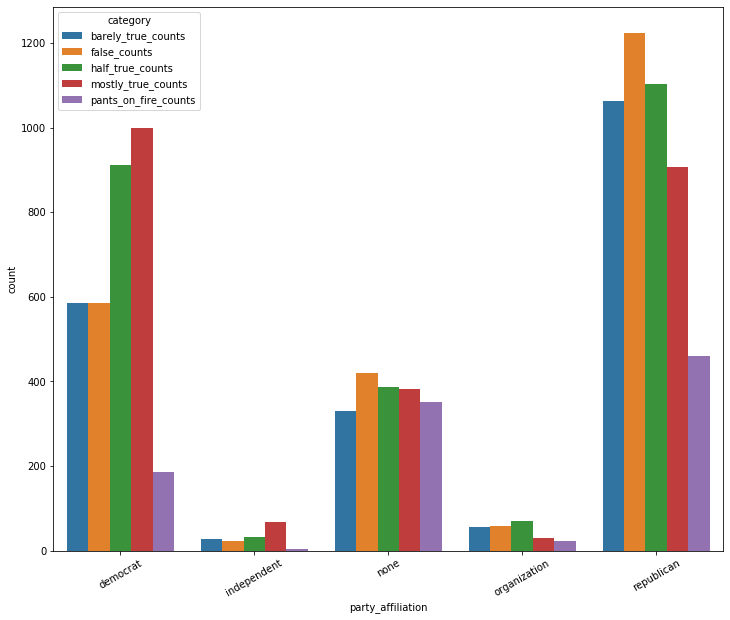

In [130]:
# Create melted DF on party affiliation
# Plot Category count by party affiliation

df_party = df_speaker_TF.groupby('party_affiliation').sum()[['barely_true_counts', 'false_counts','half_true_counts',
                                                             'mostly_true_counts', 'pants_on_fire_counts']].reset_index()
df_party_melt = pd.melt(df_party, id_vars=['party_affiliation'], value_vars=['barely_true_counts','false_counts', 'half_true_counts',
                                                          'mostly_true_counts', 'pants_on_fire_counts'])
df_party_melt = df_party_melt.rename(columns={'variable':'category', 'value':'count'})

df_top_party = df_party_melt[df_party_melt['party_affiliation'].isin(['republican','democrat','none', 'organization', 'independent'])]


plt.figure(figsize=(12,10))
sns.barplot(x='party_affiliation', y='count', data=df_top_party, hue='category')
plt.xticks(rotation = 30)